<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Preparation</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

#  Car-hailing prediction

Goal: Predict the number of car-hailing requests for the next hour in order to bring more drivers for the peak load periods. Use historical car-hailing activity data to make the prediction model with RMSE less than 48 on the test set.

## Data Preparation

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

In [2]:
#df = pd.read_csv('/datasets/taxi.csv')

df = pd.read_csv(r'C:\Users\HP\Downloads\taxi.csv')

In [3]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Datetime data type converted from object to datetime64

In [5]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Table index is set to be equal to datetime column

In [7]:
df = df.set_index('datetime')

In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Chronological check of date and time, is_monotonic index attribute is used.

In [9]:
df.index.is_monotonic

True

is_monotonic shows 'True'. Data is in chronological order.

Per hour order amount using per hour resampling

In [10]:
df = df.resample('1H').sum()

In [11]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


###### Summary

Data is uploaded and datetime format is converted to datetime64

## Analysis

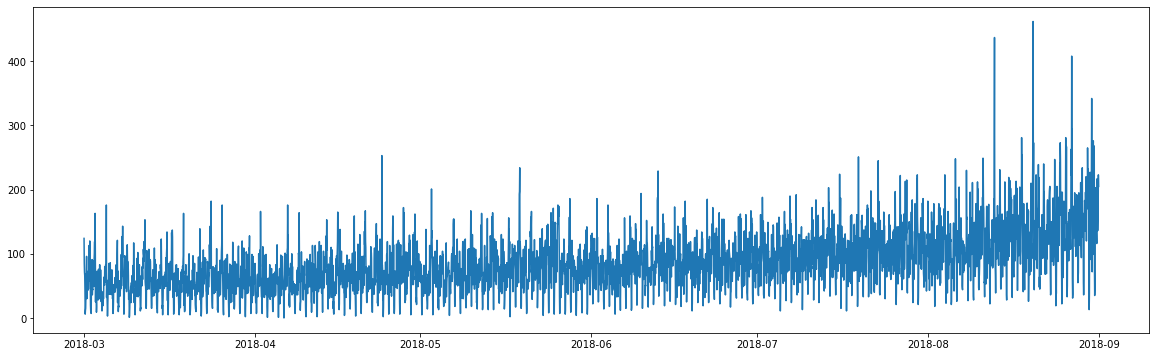

In [12]:
plt.figure(figsize=(20, 6));
plt.plot(df);

Limit amount of orders to one day data

In [13]:
df_one_day = df['2018-03-01 00:00:00':'2018-03-02 01:00:00']

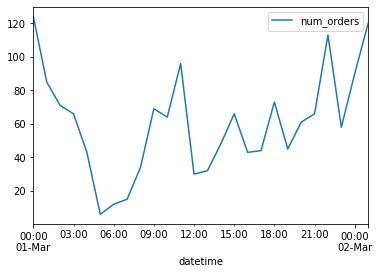

In [14]:
df_one_day.plot();

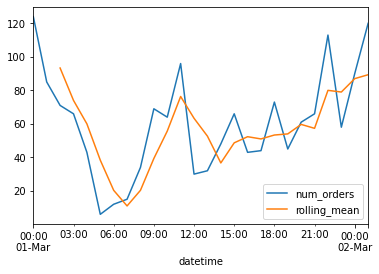

In [15]:
df_one_day['rolling_mean'] = df_one_day.rolling(3).mean()
df_one_day.plot();

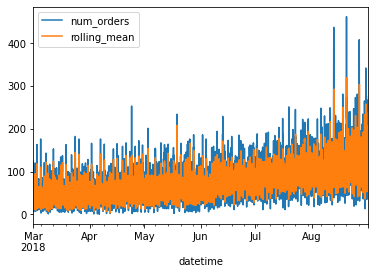

In [16]:
df['rolling_mean'] = df.rolling(3).mean()
df.plot();

###### Summary
Available data shows an increase of orders from the beginning of June. Possible explanation is the beginning of vacation season.

In [17]:
decomposed = seasonal_decompose(df['num_orders']) 

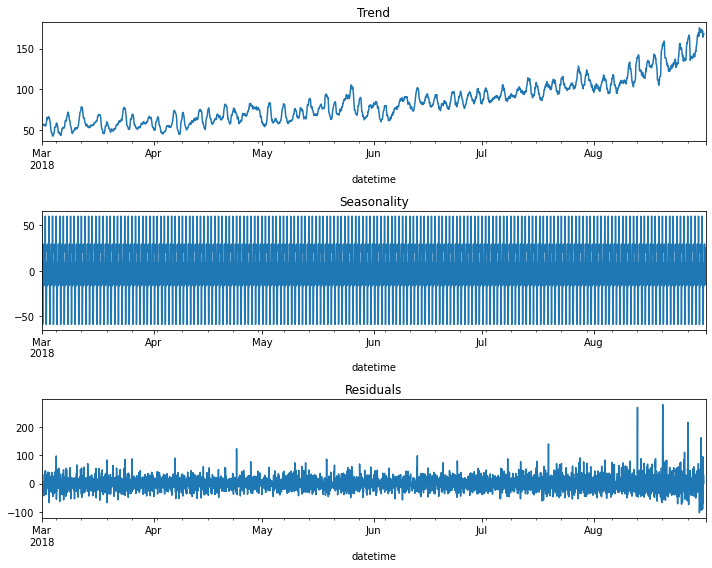

In [18]:
plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

## Training

Create new features 

In [19]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour

In [20]:
df.head()

,num_orders,rolling_mean,year,month,day,dayofweek,hour
datetime,,,,,,,
2018-03-01 00:00:00,124,NaN,2018,3,1,3,0
2018-03-01 01:00:00,85,NaN,2018,3,1,3,1
2018-03-01 02:00:00,71,93.333333,2018,3,1,3,2
2018-03-01 03:00:00,66,74.000000,2018,3,1,3,3
2018-03-01 04:00:00,43,60.000000,2018,3,1,3,4


In [21]:
df['num_orders_shifted'] = df['num_orders'].shift(2)

In [22]:
df['rolling_mean_num_orders'] = df['num_orders_shifted'].rolling(3).mean()

In [23]:
df.head()

,num_orders,rolling_mean,year,month,day,dayofweek,hour,num_orders_shifted,rolling_mean_num_orders
datetime,,,,,,,,,
2018-03-01 00:00:00,124,NaN,2018,3,1,3,0,NaN,NaN
2018-03-01 01:00:00,85,NaN,2018,3,1,3,1,NaN,NaN
2018-03-01 02:00:00,71,93.333333,2018,3,1,3,2,124.0,NaN
2018-03-01 03:00:00,66,74.000000,2018,3,1,3,3,85.0,NaN
2018-03-01 04:00:00,43,60.000000,2018,3,1,3,4,71.0,93.333333


Delete rows with missing values.

In [24]:
df.drop('rolling_mean', axis=1, inplace=True)

In [25]:
df.dropna(inplace=True)

rolling_mean column was deleted.

Split the data to training and test sets

In [26]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [27]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [28]:
model_lin_reg = LinearRegression()
model_lin_reg.fit(features_train, target_train)
train_pred_lin_reg = model_lin_reg.predict(features_train)

In [29]:
print("RMSE of the training set:", mean_squared_error(target_train, train_pred_lin_reg) ** 0.5)

RMSE of the training set: 33.247810208408445


Lightgbm with 'out of the box' parameters

In [30]:
train_data = lgb.Dataset(features_train, label=target_train)
test_data = lgb.Dataset(features_test, label=target_test)

In [31]:
parameters = {
    'application': 'regression',
    'objective': 'regression',
    'metric': 'rmse',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0,
}

In [32]:
model_lightgbm = lgb.train(parameters,
                       train_data,
                       valid_sets=test_data,                           
                       num_boost_round=500,
                       early_stopping_rounds=20,
                       )

[LightGBM] [Warning] objective is set=regression, application=regression will be ignored. Current value: objective=regression
[LightGBM] [Warning] objective is set=regression, application=regression will be ignored. Current value: objective=regression
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] objective is set=regression, application=regression will be ignored. Current value: objective=regression
[1]	valid_0's rmse: 82.9859
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 81.4675
[3]	valid_0's rmse: 80.3513
[4]	valid_0's rmse: 78.7232
[5]	valid_0's rmse: 77.3576
[6]	valid_0's rmse: 76.058
[7]	valid_0's rmse: 74.9242
[8]	valid_0's rmse: 73.7611
[9]	valid_0's rmse: 72.8892
[10]	valid_0's rmse: 72.0762
[11]	valid_0's rmse: 71.0552
[12]	valid_0's rmse: 70.444
[13]	valid_0's rmse: 69.879
[14]	valid_0's rmse: 69.1607
[1

Cross validation parameters selection

In [33]:
tscv = TimeSeriesSplit()

In [34]:
parameters = {
    'max_depth': (3, 5, 10, 13),
    "n_estimators": (30, 50, 100, 300),
    "num_leaves": (3, 5, 10, 15, 30)
}

In [35]:
rs_cv = RandomizedSearchCV(estimator=lgb.LGBMRegressor(), param_distributions=parameters, cv = tscv,n_jobs=4,
                           n_iter=100,verbose=1)
rs_cv.fit(features_train, target_train,verbose=1)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=LGBMRegressor(), n_iter=100, n_jobs=4,
                   param_distributions={'max_depth': (3, 5, 10, 13),
                                        'n_estimators': (30, 50, 100, 300),
                                        'num_leaves': (3, 5, 10, 15, 30)},
                   verbose=1)

In [36]:
rs_cv.best_params_

{'num_leaves': 30, 'n_estimators': 50, 'max_depth': 10}

## Testing

In [37]:
test_pred_lin_reg = model_lin_reg.predict(features_test)
print("RMSE of the training set for linear regression: ", \
      "{:.2f}".format(mean_squared_error(target_test, test_pred_lin_reg)** 0.5))

RMSE of the training set for linear regression:  59.94


In [38]:
predictions_model_lightgbm = model_lightgbm.predict(features_test)
print("RMSE RMSE of the training set for lightgbm: ", \
      "{:.2f}".format(mean_squared_error(target_test, predictions_model_lightgbm)** 0.5))

RMSE RMSE of the training set for lightgbm:  43.77


In [39]:
rs_cv_predict = rs_cv.predict(features_test)
print("RMSE RMSE of the training set for lightgbm with СV: ", \
      "{:.2f}".format(mean_squared_error(target_test, rs_cv_predict)** 0.5))

RMSE RMSE of the training set for lightgbm with СV:  44.85


Graphs of initial and predicted series were added.

Lightgbm model with standard parameters shows the best metric on the test set.

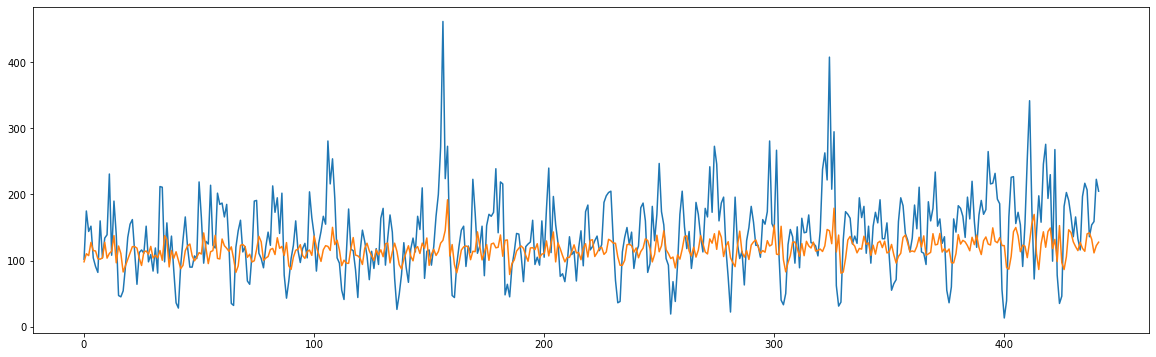

In [40]:
plt.figure(figsize=(20, 6));

plt.plot(target_test.to_numpy())

plt.plot(test_pred_lin_reg)

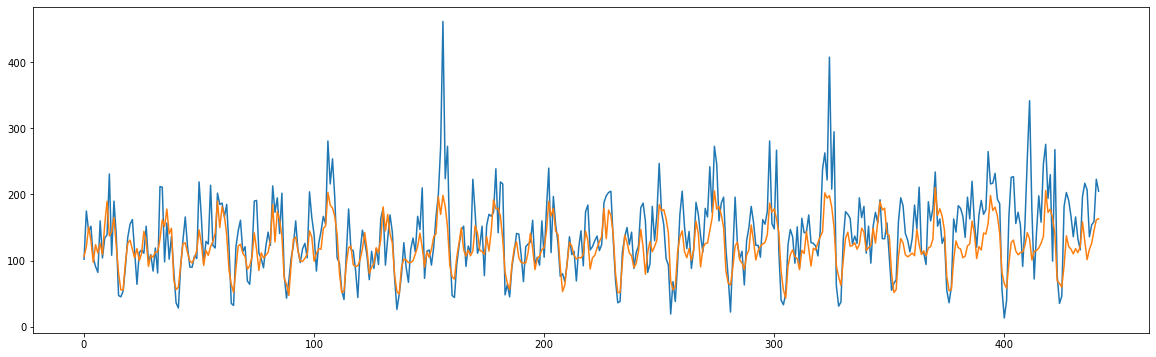

In [41]:
plt.figure(figsize=(20, 6));

plt.plot(target_test.to_numpy())

plt.plot(predictions_model_lightgbm)

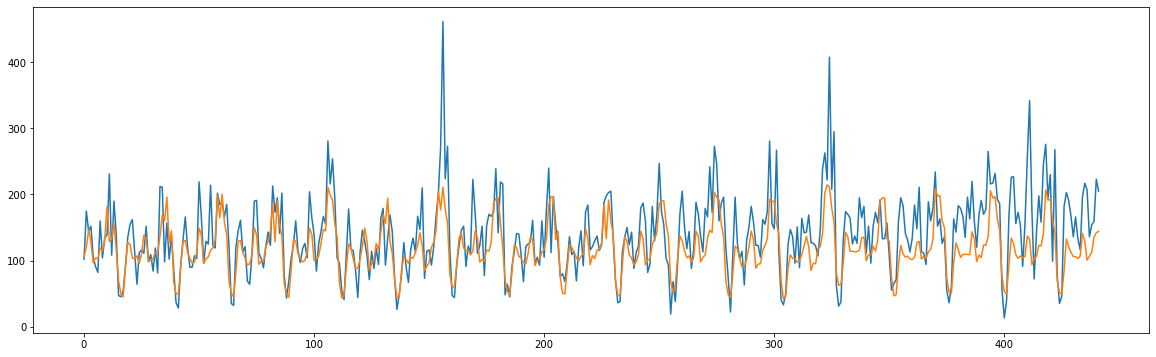

In [42]:
plt.figure(figsize=(20, 6));

plt.plot(target_test.to_numpy())

plt.plot(rs_cv_predict)

Graphs show lightgbm model predictions describing the test set quite well, except for several peak values.

## Conclusion

Lightgbm model with standard heperparameters shows the best RMSE metric (43.77) on the test set. Quality of the model corresponds to the set goal. 